## Spatially resolved analysis of mouse hypothalamus by Bulk2Space

### Jie Liao<sup>†</sup>,  Jingyang Qian<sup>†</sup>, Yin Fang<sup>†</sup>, Zhuo Chen<sup>†</sup>, Xiang Zhuang<sup>†</sup>, ..., Huajun Chen\*, Xiaohui Fan*

In this tutorial, we will show you an application of Bulk2Space to spatially deconvolve bulk transcriptome data derived from the hypothalamus region of the mouse brain using our in-house developed multiplexed barcoding RNA-seq method, termed Spatial-seq, to explain the spatial distribution of single cells and gene expression.
The processed [mouse hypothalamus bulk-seq data (GSE192999)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE192999) by Liao et.al., the [mouse hypothalamus scRNA-seq data (GSE113576)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE113576) and [MERFISH data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.8t8s248) by Moffitt et.al. can be downloaded from [here](https://github.com/FowardYang/bulk2space_data).

## Outline
1. [Import modules](#Import-modules)
2. [Parameter definition](#Parameter-definition)
3. [Load data](#Load-data)
4. [Calculate cell type proportions in bulk-seq data](#Celltype-ratio-calculation)
5. [Generate single cell expression from deconvoluted bulk-seq data](#Data-generation)
6. [Evaluation expression correlation of marker genes for cell types between scRNA-seq reference and generated single cells from bulk-seq data](#Data-Evaluation)
7. [Spatial mapping](#Spatial-Mapping)

### 1. <a id="Import-modules">Import modules</a>

In [1]:
from utils.tool import *
from utils.config import cfg, loadArgums
import numpy as np
import pandas as pd
import torch
import scanpy
from scipy.optimize import nnls
from collections import defaultdict
import argparse
import warnings
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

### 2. <a id="Parameter-definition">Parameter definition</a>

Here we applied `spot_data=False` due to using image-based spatial transcriptomics data (MERFISH) as spatial reference.

In [14]:
global args 
args = dict(
    BetaVAE_H=True,
    batch_size=512,
    data_path='lcm',
    dump_path='/home/qjy123/workspace/bulk2space_new/bulk2space/dump',
    epoch_num=3500,
    gpu_id=0,
    early_stop=50,
    hidden_lay=0,
    hidden_size=256,
    input_bulk_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/lcm/lcm_bulk.csv',
    input_sc_data_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/lcm/lcm_sc_dt.csv',
    input_sc_meta_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/lcm/lcm_sc_ct.csv',
    input_st_data_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/lcm/lcm_st_data.csv',
    input_st_meta_path='/home/qjy123/workspace/bulk2space_new/bulk2space/data/lcm/lcm_st_meta.csv',
    k=10,
    learning_rate=0.0001,
    marker_used=True,
    model_choice_1='vae', model_choice_2='df',
    load_model_1=False, train_model_2=True,
    not_early_stop=True,
    num_workers=12,
    project_name='hypothalamus_tutorial',
    ratio_num=1,
    spot_data=False,
    top_marker_num=500,
    output_path='/home/qjy123/workspace/bulk2space_new/bulk2space/output_data',
    save='/home/qjy123/workspace/bulk2space_new/bulk2space/save_model',
    random_seed=12345,
    cell_num=10,
    spot_num=500,
    max_cell_in_diff_spot_ratio=None,
    mul_test=5,
    mul_train=1,
    xtest='xtest', xtrain='xtrain', ytest='ytest', ytrain='ytrain'
)
args = argparse.Namespace(**args)

In [15]:
used_device = torch.device(f"cuda:{args.gpu_id}") if args.gpu_id >= 0 and torch.cuda.is_available() else torch.device('cpu')

In [16]:
input_sc_meta_path = args.input_sc_meta_path
input_sc_data_path = args.input_sc_data_path
input_bulk_path = args.input_bulk_path
input_st_meta_path = args.input_st_meta_path
input_st_data_path = args.input_st_data_path

### 3. <a id="Load-data">Load data</a>

In [17]:
print("loading data......")

# load sc_meta.csv file, containing two columns of cell name and cell type
input_sc_meta = pd.read_csv(input_sc_meta_path, index_col=0)
# load sc_data.csv file, containing gene expression of each cell
input_sc_data = pd.read_csv(input_sc_data_path, index_col=0)
sc_gene = input_sc_data._stat_axis.values.tolist()
# load bulk.csv file, containing one column of gene expression in bulk
input_bulk = pd.read_csv(input_bulk_path, index_col=0)
bulk_gene = input_bulk._stat_axis.values.tolist()
# filter overlapping genes.
intersect_gene = list(set(sc_gene).intersection(set(bulk_gene)))
input_sc_data = input_sc_data.loc[intersect_gene]
input_bulk = input_bulk.loc[intersect_gene]
# load st_meta.csv and st_data.csv, containing coordinates and gene expression of each spot respectively.
input_st_meta = pd.read_csv(input_st_meta_path, index_col=0)
input_st_data = pd.read_csv(input_st_data_path, index_col=0)
print("load data ok")

loading data......
load data ok


In [18]:
# Calculate marker genes of each cell type
sc = scanpy.AnnData(input_sc_data.T)
sc.obs = input_sc_meta[['Cell_type']]
scanpy.tl.rank_genes_groups(sc, 'Cell_type', method='wilcoxon')
marker_df = pd.DataFrame(sc.uns['rank_genes_groups']['names']).head(args.top_marker_num)
marker_array = np.array(marker_df)
marker_array = np.ravel(marker_array)
marker_array = np.unique(marker_array)
marker = list(marker_array)
sc_marker = input_sc_data.loc[marker, :]
bulk_marker = input_bulk.loc[marker]

... storing 'Cell_type' as categorical


In [19]:
breed = input_sc_meta['Cell_type']
breed_np = breed.values
breed_set = set(breed_np)
id2label = sorted(list(breed_set))  # List of breed
label2id = {label: idx for idx, label in enumerate(id2label)}  # map breed to breed-id

cell2label = dict()  # map cell-name to breed-id
label2cell = defaultdict(set)  # map breed-id to cell-names
for row in input_sc_meta.itertuples():
    cell_name = getattr(row, 'Cell')
    cell_type = label2id[getattr(row, 'Cell_type')]
    cell2label[cell_name] = cell_type
    label2cell[cell_type].add(cell_name)

label_devide_data = dict()
for label, cells in label2cell.items():
    label_devide_data[label] = sc_marker[list(cells)]

single_cell_splitby_breed_np = {}
for key in label_devide_data.keys():
    single_cell_splitby_breed_np[key] = label_devide_data[key].values  # [gene_num, cell_num]
    single_cell_splitby_breed_np[key] = single_cell_splitby_breed_np[key].mean(axis=1)

max_decade = len(single_cell_splitby_breed_np.keys())
single_cell_matrix = []

for i in range(max_decade):
    single_cell_matrix.append(single_cell_splitby_breed_np[i].tolist())


single_cell_matrix = np.array(single_cell_matrix)
single_cell_matrix = np.transpose(single_cell_matrix)  # (gene_num, label_num)

bulk_marker = bulk_marker.values  # (gene_num, 1)
bulk_rep = bulk_marker.reshape(bulk_marker.shape[0],)

### 4. <a id="Celltype-ratio-calculation">Calculate cell type proportions in bulk-seq data</a>
Bulk2Space firstly calculate the proportion of all cell types in bulk-seq data, which is employed for the subsequent single cells generation.

In [20]:
# calculate celltype proportions in bulk-seq data by NNLS
ratio = nnls(single_cell_matrix, bulk_rep)[0]
ratio = ratio/sum(ratio)
ratio_array = np.round(ratio * input_sc_meta.shape[0] * args.ratio_num)
ratio_list = [r for r in ratio_array]
cell_target_num = dict(zip(id2label, ratio_list))
cell_target_num

{'Astrocyte': 6193.0,
 'Endothelial': 1105.0,
 'Ependymal': 3464.0,
 'Excitatory': 1709.0,
 'Fibroblast': 0.0,
 'Inhibitory': 6589.0,
 'Macrophage': 2796.0,
 'Microglia': 1061.0,
 'Mural/Pericytes': 5127.0,
 'OD Immature': 0.0,
 'OD Mature': 2327.0,
 'OD Newly formed': 0.0}

In [21]:
# *********************************************************************
# input：data， celltype， bulk & output: label, dic, single_cell
single_cell = input_sc_data.values.T  
index_2_gene = (input_sc_data.index).tolist()
breed = input_sc_meta['Cell_type']
breed_np = breed.values
breed_set = set(breed_np)
breed_2_list = list(breed_set)
dic = {}
label = []  # the label of cell (with index correspond)
cfg.nclass = len(breed_set)

cfg.ntrain = single_cell.shape[0]
cfg.FeaSize = single_cell.shape[1]
args.feature_size = single_cell.shape[1]
assert cfg.nclass == len(cell_target_num.keys()), "cell type num no match!!!"

for i in range(len(breed_set)):
    dic[breed_2_list[i]] = i
cell = input_sc_meta["Cell"].values

for i in range(cell.shape[0]):
    label.append(dic[breed_np[i]])

label = np.array(label)

# label index the data size of corresponding target
cell_number_target_num = {}
for k, v in cell_target_num.items():
    cell_number_target_num[dic[k]] = v
# *********************************************************************
# generate data by vae
load_model_1 = args.load_model_1
model_choice_1 = args.model_choice_1

In [22]:
if not load_model_1:  # train
    print("begin vae model training...")
    # ********************* training *********************
    net = train_vae(args, single_cell, cfg, label, used_device)
    # ************** training finished *******************
    print("vae training finished!")
else:  # load model
    print("begin vae model loading...")
    net = load_vae(args, cfg, used_device)
    print("vae load finished!")

begin vae model training...


Train Epoch: 3499: 100%|██████████| 3500/3500 [8:57:14<00:00,  9.21s/it, loss=5.9116, min_loss=5.9099]  


min loss = 5.909883223474026
vae training finished!


### 5. <a id="Data-generation">Generate single cell expression from deconvoluted bulk-seq data</a>

In [ ]:
# generate and out put
generate_sc_meta, generate_sc_data = generate_vae(net, args, ratio, single_cell, cfg, label, breed_2_list, index_2_gene, cell_number_target_num, used_device)

Generate Epoch: 50: 100%|██████████| 30371/30371.0 [03:32<00:00, 143.15it/s]


generated done!
begin data to spatial mapping...


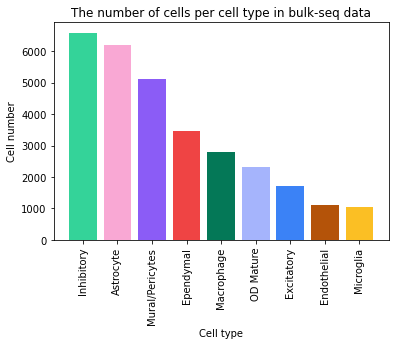

In [12]:
# The number of cells per cell type in deconvoluted bulk-seq data
ct_stat = pd.DataFrame(generate_sc_meta['Cell_type'].value_counts())
ct_name = list(ct_stat.index)
ct_num = list(ct_stat['Cell_type'])
color = ["#34D399", "#F9A8D4", '#8B5CF6', "#EF4444", '#047857', '#A5B4FC', "#3B82F6", '#B45309', '#FBBF24']
plt.bar(ct_name, ct_num, color=color)
plt.xticks(ct_name, ct_name, rotation=90)
plt.title("The number of cells per cell type in bulk-seq data")
plt.xlabel("Cell type")
plt.ylabel("Cell number")
plt.show()

### 6. <a id="Data-Evaluation">Evaluation expression correlation of marker genes for cell types between scRNA-seq reference and generated single cells from bulk-seq data</a>

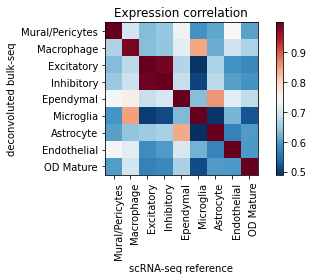

In [26]:
# Expression correlation of marker genes for cell types between scRNA-seq reference and deconvoluted bulk-seq data
# scRNA-seq reference
sc_marker_new = sc_marker.T
sc_marker_new['Cell_type'] = input_sc_meta['Cell_type']
sc_marker_mean = sc_marker_new.groupby('Cell_type')[marker].mean()

# deconvoluted bulk-seq data
generate_sc_meta.index = list(generate_sc_meta['Cell'])
generate_sc_data_new = generate_sc_data.T
generate_sc_data_new['Cell_type'] = generate_sc_meta['Cell_type']
generate_sc_data_mean = generate_sc_data_new.groupby('Cell_type')[marker].mean()

intersect_cell = list(set(sc_marker_mean.index).intersection(set(generate_sc_data_mean.index)))
generate_sc_data_mean= generate_sc_data_mean.loc[intersect_cell]
sc_marker_mean= sc_marker_mean.loc[intersect_cell]

# calculate correlation
sc_marker_mean = sc_marker_mean.T
generate_sc_data_mean = generate_sc_data_mean.T

coeffmat = np.zeros((sc_marker_mean.shape[1], generate_sc_data_mean.shape[1]))
for i in range(sc_marker_mean.shape[1]):    
    for j in range(generate_sc_data_mean.shape[1]):        
        corrtest = pearsonr(sc_marker_mean[sc_marker_mean.columns[i]], generate_sc_data_mean[generate_sc_data_mean.columns[j]])  
        coeffmat[i,j] = corrtest[0]
        
rf_ct = list(sc_marker_mean.columns)
generate_ct = list(generate_sc_data_mean.columns)

# plot
fig, ax = plt.subplots()
im = ax.imshow(coeffmat, cmap='RdBu_r')
ax.set_xticks(np.arange(len(rf_ct)))
ax.set_xticklabels(rf_ct)
ax.set_yticks(np.arange(len(generate_ct)))
ax.set_yticklabels(generate_ct)
plt.xlabel("scRNA-seq reference")
plt.ylabel("deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.colorbar(im)
ax.set_title("Expression correlation")
fig.tight_layout()
plt.show()

In [27]:
# saving.....
path = osp.join(args.output_path, args.project_name, 'predata')
if not osp.exists(path):
    os.makedirs(path)
name = "vae"
# kl_loss BetaVAE_H
if args.BetaVAE_H:
    name = "BetaVAE"
path_label_generate_csv = os.path.join(path, args.project_name + "_celltype_pred_" + name + "_epoch" + str(args.epoch_num) + '_lr' + str(args.learning_rate) + ".csv")
path_cell_generate_csv = os.path.join(path, args.project_name + "_data_pred_" + name + "_epoch" + str(args.epoch_num) + '_lr' + str(args.learning_rate) + ".csv")

generate_sc_meta.to_csv(path_label_generate_csv)
generate_sc_data.to_csv(path_cell_generate_csv)

print("bulk deconvolution finish!")

print('start to map data to space...')

bulk deconvolution finish!
start to map data to space...


### 7. <a id="Spatial-Mapping">Spatial mapping</a>
Here we applied image-based (MERFISH) spatial transcriptomics data as spatial reference.

In [37]:
# spatial mapping
print('start to process image-based st data...')
sc_gene_2 = generate_sc_data._stat_axis.values.tolist()
st_gene_2 = input_st_data._stat_axis.values.tolist()
intersect_gene_2 = list(set(sc_gene_2).intersection(set(st_gene_2)))
generate_sc_data_2 = generate_sc_data.loc[intersect_gene_2]
input_st_data_2 = input_st_data.loc[intersect_gene_2]

sc_cell_rename = [f'SC_{i}' for i in range(1, generate_sc_data_2.shape[1] + 1)]
generate_sc_data.columns = generate_sc_data_2.columns = sc_cell_rename
generate_sc_meta = generate_sc_meta.drop(['Cell'], axis=1)
generate_sc_meta.insert(0, 'Cell', sc_cell_rename)
generate_sc_meta['Batch'] = 'sc'
generate_sc_meta_2 = generate_sc_meta.drop(['Cell_type'], axis=1)
st_cell_rename = [f'ST_{i}' for i in range(1, input_st_data_2.shape[1] + 1)]
input_st_data.columns = input_st_data_2.columns = st_cell_rename
input_st_meta = input_st_meta.drop(['Cell'], axis=1)
input_st_meta.insert(0, 'Cell', st_cell_rename)
input_st_meta_2 = pd.DataFrame({'Cell': st_cell_rename, 'Batch': 'st'})

all_data = generate_sc_data_2.join(input_st_data_2)
all_meta = pd.concat([generate_sc_meta_2, input_st_meta_2], ignore_index=True)
joint_data = joint_analysis(all_data, all_meta['Batch'], ref_batch="st")
joint_data[joint_data < 0] = 0
sc_data_new = joint_data.iloc[:, 0:generate_sc_data_2.shape[1]]
st_data_new = joint_data.iloc[:, generate_sc_data_2.shape[1]:all_data.shape[1]]

_, ind = knn(data=sc_data_new.T, query=st_data_new.T, k=10)

st_data_pred = pd.DataFrame()
st_meta_pred = pd.DataFrame(columns=['Cell', 'Cell_type'])

for i in range(len(st_cell_rename)):
    st_data_pred[st_cell_rename[i]] = list(generate_sc_data.iloc[:, ind[i]].mean(axis=1))
    ct_tmp = list(generate_sc_meta.iloc[ind[i], :].Cell_type)
    ct_pred = max(ct_tmp, key=ct_tmp.count)
    st_meta_pred.loc[st_cell_rename[i]] = [st_cell_rename[i], ct_pred]

st_data_pred.index = generate_sc_data.index
st_meta_pred = pd.merge(st_meta_pred, input_st_meta, how='left', on='Cell')

start to process image-based st data...


Bulk2Space successfully predicted whole gene expression profiles of MERFISH data.

In [38]:
input_st_data.shape

(155, 6154)

In [39]:
st_data_pred.shape

(17757, 6154)

In [40]:
st_meta_pred

,Cell,Cell_type,xcoord,ycoord
0,ST_1,Mural/Pericytes,-3033.401378,2825.155877
1,ST_2,Astrocyte,-3030.516232,2856.104116
2,ST_3,Inhibitory,-3027.328655,2955.936449
3,ST_4,Ependymal,-3025.209601,2923.090153
4,ST_5,Inhibitory,-3020.512953,2961.696710
...,...,...,...,...
6149,ST_6150,Inhibitory,-1430.985128,4324.073355
6150,ST_6151,Inhibitory,-1347.375032,4421.562114
6151,ST_6152,Inhibitory,-1365.432026,4412.294335
6152,ST_6153,Astrocyte,-1285.318870,4407.337020


The spatial distribution of distinct cells in Bulk2Space results showed significant spatial patterns.

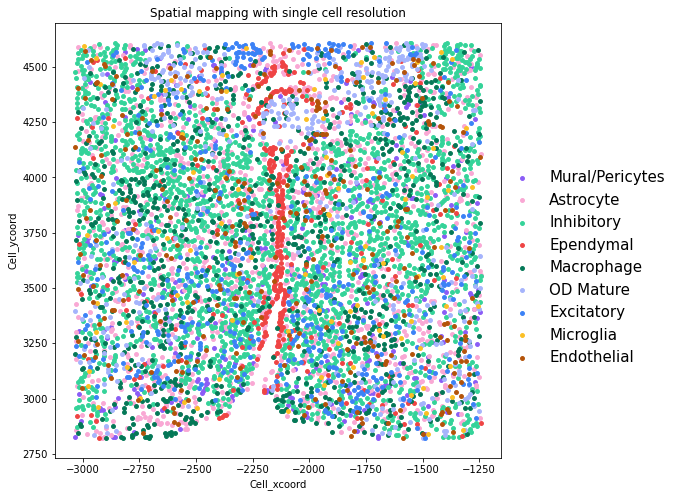

In [42]:
# Spatial mapping with single cell resolution
ct_type = list(st_meta_pred['Cell_type'].unique())
color = ["#8B5CF6", "#F9A8D4", '#34D399', "#EF4444", '#047857', '#A5B4FC', "#3B82F6", '#FBBF24', '#B45309']

fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(ct_type)):
    ax.scatter(st_meta_pred.loc[st_meta_pred.Cell_type == ct_type[i], 'xcoord'],
               st_meta_pred.loc[st_meta_pred.Cell_type == ct_type[i], 'ycoord'],
               color = color[i], label = ct_type[i], s = 15)


plt.title("Spatial mapping with single cell resolution")
plt.xlabel("Cell_xcoord")
plt.ylabel("Cell_ycoord")
plt.legend(bbox_to_anchor=(1, 0.2), loc=3, borderaxespad=0, frameon=False, fontsize=15)
plt.show()    

We firstly investigate the Bulk2Space predicted and MERFISH measured spatial expression of targeted genes, and the results showed that the spatial expression patterns were consistant with each other.

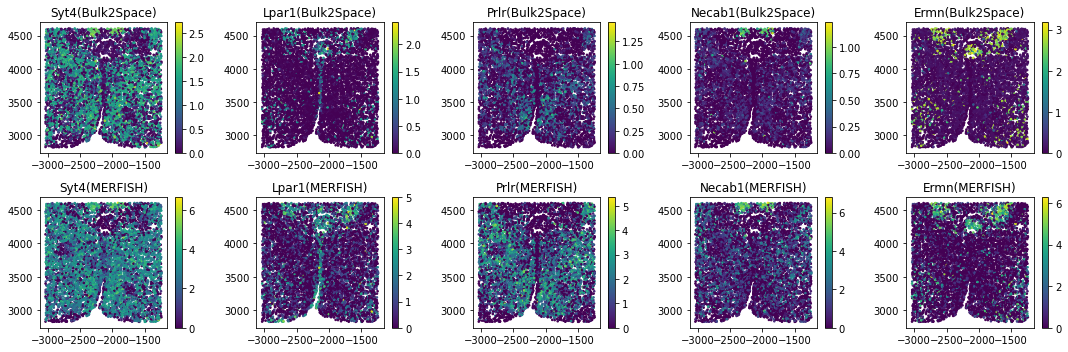

In [46]:
# The Bulk2Space predicted and MERFISH measured spatial expression of targeted genes
# gene expression (Bulk2Space)
plot1 = st_meta_pred
plot1.index = list(plot1['Cell'])
gene = ['Syt4', 'Lpar1', 'Prlr', 'Necab1', 'Ermn']
plot1[gene] = st_data_pred.T[gene]
xcoord = np.array(plot1['xcoord'])
ycoord = np.array(plot1['ycoord'])
gene1 = np.array(plot1['Syt4'])
gene2 = np.array(plot1['Lpar1'])
gene3 = np.array(plot1['Prlr'])
gene4 = np.array(plot1['Necab1'])
gene5 = np.array(plot1['Ermn'])

# gene expression (MERFISH)
plot2 = input_st_meta
plot2.index = list(plot2['Cell'])
gene = ['Syt4', 'Lpar1', 'Prlr', 'Necab1', 'Ermn']
plot2[gene] = np.log2(input_st_data + 1).T[gene]
xcoord = np.array(plot2['xcoord'])
ycoord = np.array(plot2['ycoord'])
gene6 = np.array(plot2['Syt4'])
gene7 = np.array(plot2['Lpar1'])
gene8 = np.array(plot2['Prlr'])
gene9 = np.array(plot2['Necab1'])
gene10 = np.array(plot2['Ermn'])

# plot
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

p1 = axs[0, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene1)
fig.colorbar(p1, ax=axs[0, 0])
axs[0, 0].set_title('Syt4(Bulk2Space)')

p2 = axs[0, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene2)
fig.colorbar(p2, ax=axs[0, 1])
axs[0, 1].set_title('Lpar1(Bulk2Space)')

p3 = axs[0, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene3)
fig.colorbar(p3, ax=axs[0, 2])
axs[0, 2].set_title('Prlr(Bulk2Space)')

p4 = axs[0, 3].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene4)
fig.colorbar(p4, ax=axs[0, 3])
axs[0, 3].set_title('Necab1(Bulk2Space)')

p5 = axs[0, 4].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene5)
fig.colorbar(p5, ax=axs[0, 4])
axs[0, 4].set_title('Ermn(Bulk2Space)')


p6 = axs[1, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene6)
fig.colorbar(p6, ax=axs[1, 0])
axs[1, 0].set_title('Syt4(MERFISH)')

p7 = axs[1, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene7)
fig.colorbar(p7, ax=axs[1, 1])
axs[1, 1].set_title('Lpar1(MERFISH)')

p8 = axs[1, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene8)
fig.colorbar(p8, ax=axs[1, 2])
axs[1, 2].set_title('Prlr(MERFISH)')

p9 = axs[1, 3].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene9)
fig.colorbar(p9, ax=axs[1, 3])
axs[1, 3].set_title('Necab1(MERFISH)')

p10 = axs[1, 4].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene10)
fig.colorbar(p10, ax=axs[1, 4])
axs[1, 4].set_title('Ermn(MERFISH)')


plt.tight_layout()
plt.show()

Further more, Bulk2Space could also Predict spatial expression patterns of novel marker genes for different cell types.

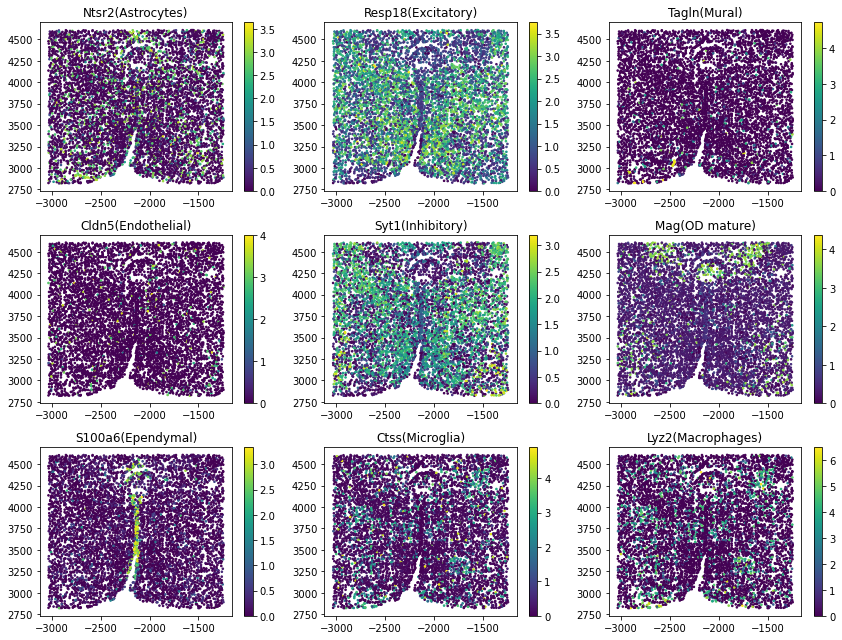

In [49]:
# The Bulk2Space predicted spatial expression of genes that not measured in MERFISH
# gene expression (Bulk2Space)
# Astrocytes (Ntsr2), Excitatory (Resp18), Mural (Tagln), Endothelial (Cldn5), Inhibitory (Syt1),
# OD mature (Mag), Ependymal (S100a6), Microglia (Ctss), Macrophages (Lyz2)

plot = st_meta_pred
plot.index = list(plot['Cell'])
gene = ['Ntsr2', 'Resp18', 'Tagln', 'Cldn5', 'Syt1', 'Mag', 'S100a6', 'Ctss', 'Lyz2']
plot[gene] = st_data_pred.T[gene]
xcoord = np.array(plot['xcoord'])
ycoord = np.array(plot['ycoord'])
gene1 = np.array(plot['Ntsr2'])
gene2 = np.array(plot['Resp18'])
gene3 = np.array(plot['Tagln'])
gene4 = np.array(plot['Cldn5'])
gene5 = np.array(plot['Syt1'])
gene6 = np.array(plot['Mag'])
gene7 = np.array(plot['S100a6'])
gene8 = np.array(plot['Ctss'])
gene9 = np.array(plot['Lyz2'])


# plot
fig, axs = plt.subplots(3, 3, figsize=(12, 9))

p1 = axs[0, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene1)
fig.colorbar(p1, ax=axs[0, 0])
axs[0, 0].set_title('Ntsr2(Astrocytes)')

p2 = axs[0, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene2)
fig.colorbar(p2, ax=axs[0, 1])
axs[0, 1].set_title('Resp18(Excitatory)')

p3 = axs[0, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene3)
fig.colorbar(p3, ax=axs[0, 2])
axs[0, 2].set_title('Tagln(Mural)')

p4 = axs[1, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene4)
fig.colorbar(p4, ax=axs[1, 0])
axs[1, 0].set_title('Cldn5(Endothelial)')

p5 = axs[1, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene5)
fig.colorbar(p5, ax=axs[1, 1])
axs[1, 1].set_title('Syt1(Inhibitory)')

p6 = axs[1, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene6)
fig.colorbar(p6, ax=axs[1, 2])
axs[1, 2].set_title('Mag(OD mature)')

p7 = axs[2, 0].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene7)
fig.colorbar(p7, ax=axs[2, 0])
axs[2, 0].set_title('S100a6(Ependymal)')

p8 = axs[2, 1].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene8)
fig.colorbar(p8, ax=axs[2, 1])
axs[2, 1].set_title('Ctss(Microglia)')

p9 = axs[2, 2].scatter(xcoord, ycoord, s=2.5, cmap='viridis', c=gene9)
fig.colorbar(p9, ax=axs[2, 2])
axs[2, 2].set_title('Lyz2(Macrophages)')

plt.tight_layout()
plt.show()
